In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from deepface import DeepFace
from deepface.commons import functions

#!pip install redis
import redis

# Face Recognition Model

In [2]:
model = DeepFace.build_model("Facenet")

In [3]:
input_shape = (160, 160)
target_shape = 128

# Target

In [4]:
target_img_path = "target.png"
target_img = functions.preprocess_face(target_img_path, target_size = (160, 160))

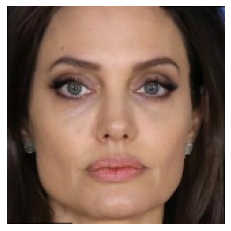

In [5]:
plt.imshow(target_img[0][:,:,::-1])
plt.axis('off')
plt.show()

In [6]:
target_embedding = model.predict(target_img)[0].tolist()

# Getting Redis Server Up

In [7]:
#redis = redis.Redis(host='localhost', port=6379, db=0)
redis = redis.StrictRedis(host='localhost', port=6379, db=0)

In [8]:
for key in redis.scan_iter("embedding:*"):
    redis.delete(key)

for key in redis.scan_iter("photo:*"):
    redis.delete(key)

# Store local db in Redis

In [9]:
#Ref: https://github.com/serengil/deepface/tree/master/tests/dataset
local_db = {
    'angelina': 'deepface/tests/dataset/img2.jpg',
    'jennifer': 'deepface/tests/dataset/img56.jpg',
    'scarlett': 'deepface/tests/dataset/img49.jpg',
    'katy': 'deepface/tests/dataset/img42.jpg',
    'marissa': 'deepface/tests/dataset/img23.jpg'
}

In [10]:
identities = list(local_db.keys())

for i in tqdm(range(0, len(identities))):
    name = identities[i]
    img_path = local_db[name]
    
    img = functions.preprocess_face(img_path, target_size = (160, 160))
    embedding = model.predict(img)[0].tolist() 
    
    redis.rpush("embedding:"+name, *embedding)
    redis.set("photo:"+name, img_path)

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


# Subsdiary functions

In [11]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

# Face verification

In [12]:
def verify_face(key):
    embedding = redis.lrange('embedding:'+key, 0, -1)
    
    #print(embedding)
    #print(np.array(embedding).astype('float'))
    
    distance = findEuclideanDistance(target_embedding, np.array(embedding).astype('float'))
    print("Distance is ",distance)
    
    img_name = redis.get('photo:'+key).decode()
    source_img = functions.preprocess_face(img_name)
    
    #------------------------------------
    
    fig = plt.figure(figsize = (7, 7))
    
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(target_img[0][:, :, ::-1])
    plt.axis('off')
    
    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(source_img[0][:, :, ::-1])
    plt.axis('off')
    
    plt.show()
    
    #------------------------------------
    
    if distance <= 10:
        print("this is "+key)
    else:
        print("this IS NOT "+key)

Distance is  7.091028809736962


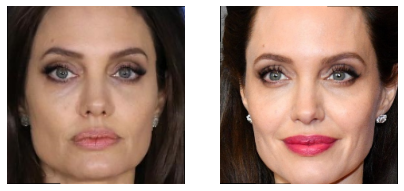

this is angelina


In [13]:
verify_face('angelina')

Distance is  15.558933639766593


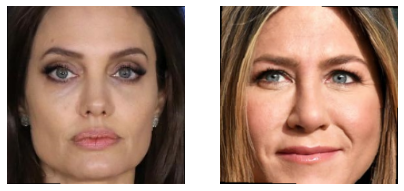

this IS NOT jennifer


In [14]:
verify_face('jennifer')

Distance is  13.540920216203633


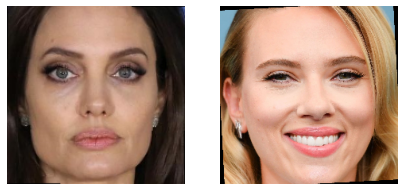

this IS NOT scarlett


In [15]:
verify_face('scarlett')

Distance is  16.35871620520999


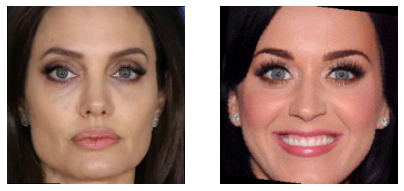

this IS NOT katy


In [16]:
verify_face('katy')

Distance is  15.984569374847371


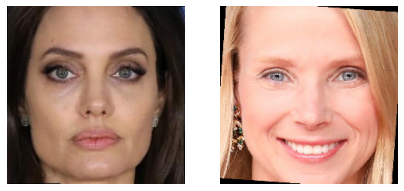

this IS NOT marissa


In [17]:
verify_face('marissa')

# Server side face verification

In [18]:
verify_script = '''
local source = KEYS[1]
local source_embedding = redis.call("lrange", "embedding:"..source, 0, -1)

local distance = 0
for i = 1, #source_embedding do
    distance = distance + (source_embedding[i] - KEYS[1+i])^2
end

distance = math.sqrt(distance)

return {"euclidean_distance", tostring(distance)}
'''

In [19]:
command = redis.register_script(verify_script)

In [20]:
float(command(keys = ["angelina", *target_embedding])[1].decode()) <= 10

True

In [21]:
float(command(keys = ["jennifer", *target_embedding])[1].decode()) <= 10

False

In [22]:
float(command(keys = ["katy", *target_embedding])[1].decode()) <= 10

False

In [23]:
float(command(keys = ["scarlett", *target_embedding])[1].decode()) <= 10

False

In [24]:
float(command(keys = ["marissa", *target_embedding])[1].decode()) <= 10

False

# Server side face recognition

In [25]:
find_script = '''
local db = redis.call("SCAN", 0, "MATCH", "embedding:*")[2]

local identities = {}
local distances = {}

local idx = 1
for i=1, #db do
    local source_key = db[i]
    local source_embedding = redis.call("lrange", source_key, 0, -1)
    
    local distance = 0
    for j=1, #source_embedding do
        distance = distance + (source_embedding[j] - KEYS[j])^2
    end
    
    distance = math.sqrt(distance)
    
    if distance <= 10 then
        distances[idx] = tostring(distance)
        identities[idx] = source_key
        idx = idx + 1
    end
    
end

return {identities, distances}
'''

In [26]:
command = redis.register_script(find_script)

In [27]:
results = command(keys = [*target_embedding])

In [28]:
results

[[b'embedding:angelina'], [b'7.091028809737']]